# Условие задачи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг

Два основных типа услуг: 

1. Стационарная телефонная связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

`customerID` - код клиента.

	
<div class='alert alert-success'> 👍
Спасибо за описание задачи, важно держать такую информацию перед глазами!


# Описание полей данных

BeginDate – дата начала пользования услугами,
EndDate – дата окончания пользования услугами,
Type – тип оплаты: ежемесячный, годовой и тд,
PaperlessBilling – безналичный расчет,
PaymentMethod – способ оплаты,
MonthlyCharges – ежемесячные траты на услуги,
TotalCharges – всего потрачено денег на услуги
Dependents – наличие иждивенцев
Senior Citizen – наличие пенсионного статуса по возрасту
Partner – наличие супруга(и)
MultipleLines – наличие возможности ведения параллельных линий во время звонка

0 sp AUC-ROC < 0.75

4 sp 0.75 ≤ AUC-ROC < 0.81

4.5 sp 0.81 ≤ AUC-ROC < 0.85

5 sp 0.85 ≤ AUC-ROC < 0.87

5.5 sp 0.87 ≤ AUC-ROC < 0.88

6 sp AUC-ROC ≥ 0.88

RANDOM_STATE = 121222

# План решения задачи


Первый этап:

1. Загрузка данных
2. Исследовательский анализ данных. 
Делаем первичную предобработку данных, проверяем пропуски, дубликаты, нужного ли типа данные. Делаем их визуализацию. 
3. Моделирование
Обучаем модели, подбираем гиперпараметры, проверяем на кросс валидацию.
4. Тестирование
Делаем подсчет метрик и выводы

Второй этап:

Разделяем данные на тест (25% данных) и трейн, фиксируем random state.
Таргет определяется по полю end_date, если присутствует дата, значит клиент ушел, иначе клиент все еще пользуется нашими услугами. Дата выгрузки датасета 1 февраля 2020 года. 
На тест отправляется только лучшая модель, выбранная на кросс валидации.

Третий этап:
Подготовить отчет с ответом на вопросы.

<div class='alert alert-success'> 👍	    
У тебя получился отличный план, продолжай работу над проектом в соотвествии с его пунктами! 


## Загрузка данных

In [1]:
#импорты библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time


import warnings
warnings.filterwarnings("ignore")

from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_val_score
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

RANDOM_STATE = 121222

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

<div class='alert alert-success'> 👍 Отличное начало

In [3]:
def data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe())
    print(' ')
    print('пропуски:', data.isna().sum())
    print(' ')
    print('дубликаты:', data.duplicated().sum())
    print(' ')
    for column in data.columns:
        print('уникальные значения', column)
        print(data[column].sort_values().unique())  

In [4]:
data_info(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2832,0635-WKOLD,2016-10-01,No,One year,No,Credit card (automatic),70.75,2921.75
709,3347-YJZZE,2017-09-01,No,Month-to-month,No,Credit card (automatic),80.10,2211.8
6349,3451-VAWLI,2017-03-01,No,Two year,No,Credit card (automatic),19.70,730.4
4884,2359-KLTEK,2016-09-01,No,Month-to-month,Yes,Bank transfer (automatic),94.90,3848
5749,3349-ANQNH,2015-03-01,No,One year,Yes,Electronic check,99.50,5890


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


 
пропуски: customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
 
дубликаты: 0
 
уникальные значения customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
уникальные значения BeginDate
['2013-10-01' '2013-11-01' '2013-12-01' '2014-01-01' '2014-02-01'
 '2014-03-01' '2014-04-01' '2014-05-01' '2014-06-01' '2014-07-01'
 '2014-08-01' '2014-09-01' '2014-10-01' '2014-11-01' '2014-12-01'
 '2015-01-01' '2015-02-01' '2015-03-01' '2015-04-01' '2015-05-01'
 '2015-06-01' '2015-07-01' '2015-08-01' '2015-09-01' '2015-10-01'
 '2015-11-01' '2015-12-01' '2016-01-01' '2016-02-01' '2016-03-01'
 '2016-04-01' '2016-05-01' '2016-06-01' '2016-07-01' '2016-08-01'
 '2016-09-01' '2016-10-01' '2016-11-01' '2016-12-01' '2017-01-01'
 '2017-02-01' '2017-03-01' '2017-04-01' '2017-05-01' '2017-06-01'
 '2017-07-01' '2017-08-01' '2017-09-01' '2

In [5]:
data_info(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
1114,3312-UUMZW,Male,0,Yes,No
4359,9133-AYJZG,Female,0,No,No
170,7654-YWJUF,Male,0,Yes,No
4032,4098-NAUKP,Male,1,Yes,Yes
4822,2664-XJZNO,Male,0,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


 
пропуски: customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
 
дубликаты: 0
 
уникальные значения customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
уникальные значения gender
['Female' 'Male']
уникальные значения SeniorCitizen
[0 1]
уникальные значения Partner
['No' 'Yes']
уникальные значения Dependents
['No' 'Yes']


In [6]:
data_info(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3139,9667-TKTVZ,DSL,No,No,No,Yes,No,No
2931,4806-HIPDW,Fiber optic,No,No,No,No,No,No
3358,2192-OZITF,DSL,Yes,No,No,Yes,No,Yes
3086,5154-VEKBL,DSL,Yes,No,Yes,Yes,Yes,Yes
2483,7395-IGJOS,Fiber optic,No,No,No,No,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2969-VAPYH,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


 
пропуски: customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
 
дубликаты: 0
 
уникальные значения customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
уникальные значения InternetService
['DSL' 'Fiber optic']
уникальные значения OnlineSecurity
['No' 'Yes']
уникальные значения OnlineBackup
['No' 'Yes']
уникальные значения DeviceProtection
['No' 'Yes']
уникальные значения TechSupport
['No' 'Yes']
уникальные значения StreamingTV
['No' 'Yes']
уникальные значения StreamingMovies
['No' 'Yes']


In [7]:
data_info(phone)

,customerID,MultipleLines
1915,4137-BTIKL,Yes
5636,0130-SXOUN,Yes
49,4667-QONEA,No
3268,6128-CZOMY,No
6081,2061-VVFST,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,4325-NFSKC,No
freq,1,3390


 
пропуски: customerID       0
MultipleLines    0
dtype: int64
 
дубликаты: 0
 
уникальные значения customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-RRAMN' '9992-UJOEL'
 '9993-LHIEB']
уникальные значения MultipleLines
['No' 'Yes']


***Выводы:***

1. Пропусков и дубликатов нет
2. Все значения BeginDate и EndDate лучше перевести в формат даты, подставить 1 февраля 2020 года в значения с 'No'
3. Лучше обьеденить данные в 1 таблицу
4. Многие значения с ['No' 'Yes'] нужно будет перевести в 1 и 0
5. Данные есть не по всем клиентам

<div class='alert alert-success'> 👍	
Хорошее первичное знакомство с данными, не забывай про метод describe и используй его с  аргументом include=’all’


## Исследовательский анализ данных

In [8]:
# Объединяем данные
alldata = contract.set_index('customerID').join(personal.set_index('customerID'))
alldata = alldata.join(internet.set_index('customerID'))
alldata = alldata.join(phone.set_index('customerID'))
alldata

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN


<div class='alert alert-success'> 👍
Помни о том, что при объединении датафреймов очень часто случаются потери данных. Ты вывел размер и пример датафрейма, не забывай до этого также оценить размер данных

In [9]:
data_info(alldata)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7969-AULMZ,2018-03-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,97.35,2119.5,Female,0,No,No,Fiber optic,No,No,No,No,Yes,Yes,Yes
9274-UARKJ,2018-11-01,No,Month-to-month,Yes,Bank transfer (automatic),83.20,1130,Female,0,No,No,Fiber optic,No,Yes,No,No,Yes,No,No
8270-RKSAP,2019-05-01,No,Month-to-month,Yes,Electronic check,70.50,597.9,Male,0,No,No,Fiber optic,No,No,No,No,No,No,No
9497-QCMMS,2019-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,93.55,93.55,Male,1,No,No,Fiber optic,No,No,No,No,Yes,Yes,Yes
8884-MRNSU,2018-09-01,No,One year,No,Bank transfer (automatic),19.90,329.75,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

None

,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000


 
пропуски: BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64
 
дубликаты: 13
 
уникальные значения BeginDate
['2013-10-01' '2013-11-01' '2013-12-01' '2014-01-01' '2014-02-01'
 '2014-03-01' '2014-04-01' '2014-05-01' '2014-06-01' '2014-07-01'
 '2014-08-01' '2014-09-01' '2014-10-01' '2014-11-01' '2014-12-01'
 '2015-01-01' '2015-02-01' '2015-03-01' '2015-04-01' '2015-05-01'
 '2015-06-01' '2015-07-01' '2015-08-01' '2015-09-01' '2015-10-01'
 '2015-11-01' '2015-12-01' '2016-01-01' '2016-02-01' '2016-03-01'
 '2016-04-01' '2016-05-01' '2016-06-01' '2016-07-01' '20

In [10]:
#В первую очередь заменим пропуски на No, скорее всего это значит, что услуги не подключены у пользователя

for column in ('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'):
    alldata[column] = alldata[column].fillna('No')

<div class='alert alert-success'> 👍
Заполнение пропусков корректно 

In [11]:
#Далее преобразуем столбцы BeginDate и EndDate, заменим в последнем no на 1 февраля 2020


alldata['BeginDate'] = pd.to_datetime(alldata['BeginDate'], format='%Y-%m-%d')
alldata['EndDate'] = alldata['EndDate'].replace(['No'], ['2020-02-01'])
alldata['EndDate'] = pd.to_datetime(alldata['EndDate'], format='%Y-%m-%d')

In [12]:
data_info(alldata)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
5609-CEBID,2018-05-01,2020-01-01,Month-to-month,Yes,Electronic check,94.10,1782.4,Female,1,No,No,Fiber optic,No,Yes,Yes,No,No,Yes,Yes
4682-BLBUC,2016-06-01,2020-02-01,One year,Yes,Electronic check,70.95,3250.45,Male,0,Yes,No,DSL,No,Yes,Yes,Yes,Yes,No,No
8824-RWFXJ,2019-07-01,2019-10-01,Month-to-month,Yes,Mailed check,56.15,168.15,Male,0,Yes,Yes,DSL,No,Yes,Yes,No,No,No,No
3874-EQOEP,2019-06-01,2020-01-01,Month-to-month,No,Mailed check,95.00,655.5,Male,0,No,No,Fiber optic,No,No,No,No,Yes,Yes,Yes
7901-TBKJX,2015-06-01,2020-02-01,Month-to-month,Yes,Electronic check,101.05,5594,Male,1,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

None

,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000


 
пропуски: BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64
 
дубликаты: 13
 
уникальные значения BeginDate
['2013-10-01T00:00:00.000000000' '2013-11-01T00:00:00.000000000'
 '2013-12-01T00:00:00.000000000' '2014-01-01T00:00:00.000000000'
 '2014-02-01T00:00:00.000000000' '2014-03-01T00:00:00.000000000'
 '2014-04-01T00:00:00.000000000' '2014-05-01T00:00:00.000000000'
 '2014-06-01T00:00:00.000000000' '2014-07-01T00:00:00.000000000'
 '2014-08-01T00:00:00.000000000' '2014-09-01T00:00:00.000000000'
 '2014-10-01T00:00:00.000000000' '2014-11-01T00:00:00.000000000'
 '2014-12-01T00:00:00.000000000' '2015-01-01T00:00:00.

В TotalCharges есть уникальное значение ' ', если я правильно понимаю, пропуск значит, что человек еще ничего не потратил, поэтому можно заменить на 0. Также изменим тип данных.

In [13]:
alldata['TotalCharges'] = alldata['TotalCharges'].replace(' ', 0)
alldata['TotalCharges'] = pd.to_numeric(alldata['TotalCharges'])
alldata['TotalCharges'] = alldata['TotalCharges'].astype('int')

<div class='alert alert-warning'> ⚠️
Также данный признак можно заполнить значениями вычислив их с помощью умножения времени жизни клиента в компании на ежемесячные траты.

В MonthlyCharges тоже изменим тип данных.


In [14]:
alldata['MonthlyCharges'] = alldata['MonthlyCharges'].astype('int')

In [15]:
alldata

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29,29,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56,1889,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53,108,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42,1840,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70,151,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84,1990,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103,7362,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29,346,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No


In [16]:
# после создадим функцию, которая заменит все да на 1, а нет на 0

def nolodin(data, column):
    data[column] = data[column].replace(['No'], 0)
    data[column] = data[column].replace(['Yes'], 1)
    return data[column]

<div class='alert alert-warning'> ⚠️
Получилось, что шаг с заполнением пропусков с помощью Yes/No избыточный

In [17]:
alldata['PaperlessBilling'] = nolodin(alldata, 'PaperlessBilling')
alldata['Partner'] = nolodin(alldata, 'Partner')
alldata['Dependents'] = nolodin(alldata, 'Dependents')

alldata['OnlineSecurity'] = nolodin(alldata, 'OnlineSecurity')
alldata['OnlineBackup'] = nolodin(alldata, 'OnlineBackup')
alldata['DeviceProtection'] = nolodin(alldata, 'DeviceProtection')
alldata['TechSupport'] = nolodin(alldata, 'TechSupport')
alldata['StreamingTV'] = nolodin(alldata, 'StreamingTV')
alldata['StreamingMovies'] = nolodin(alldata, 'StreamingMovies')
alldata['MultipleLines'] = nolodin(alldata, 'MultipleLines')

<div class='alert alert-warning'> ⚠️
Попробуй выполнить это преобразование в цикле 

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Я оставила значения выше. Но Цикл с этим кодом бы выглядел так:
</div>

<div class='alert alert-success'> 👍 вер 2
Спасибо за старания!

In [18]:
columnsnole = ['PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

for column in columnsnole:
    alldata[column] = nolodin(alldata, column)

In [76]:
# сделаем следующие замены в столбцах на 1 и 0 
alldata['gender'] = pd.Series(np.where(alldata['gender'].values == 'Female', 1, 0), alldata.index)
alldata['InternetService'] = pd.Series(np.where(alldata['InternetService'].values == 'DSL', 1, 0), alldata.index)

Добавим целевой столбец 'client', отражающий факт ухода уклиента.
Если значение в столбце EndDate равно 0, то значит клиент остался, 1 - ушел. 

In [20]:
alldata['client'] = (alldata['EndDate'] != '2020-02-01').astype(int)

<div class='alert alert-success'> 👍
Таргет сформирован корректно 

In [21]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   int64         
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   int64         
 6   TotalCharges      7043 non-null   int64         
 7   gender            7043 non-null   int64         
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   int64         
 10  Dependents        7043 non-null   int64         
 11  InternetService   7043 non-null   int64         
 12  OnlineSecurity    7043 non-null   int64         
 13  OnlineBackup      7043 non-null   int64         
 14  DeviceProtecti

<div class='alert alert-danger'> ⛔️
Не хватает промежуточных выводов, подведи итог с тем что сделано 

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Добавила промежуточные выводы
</div>

***Промежуточные выводы:***

На этом этапе сделали первичную обработку: 

- Были бъединины все данные в один датафрейм, данные также перевели в нужный формат
- Были найдены и заполнены аномалии, так как данные не заполнились корректно
- Избавились от пропусков, в большинстве случаев это были доп услуги и это значило, что они были не подключены
- Добавили целевой столбец 'client', отражающий факт ухода уклиента. Если значение в столбце EndDate равно 0, то значит клиент остался, 1 - ушел


<div class='alert alert-success'> 👍 вер 2
Хорошая работа!

## Визуализация данных

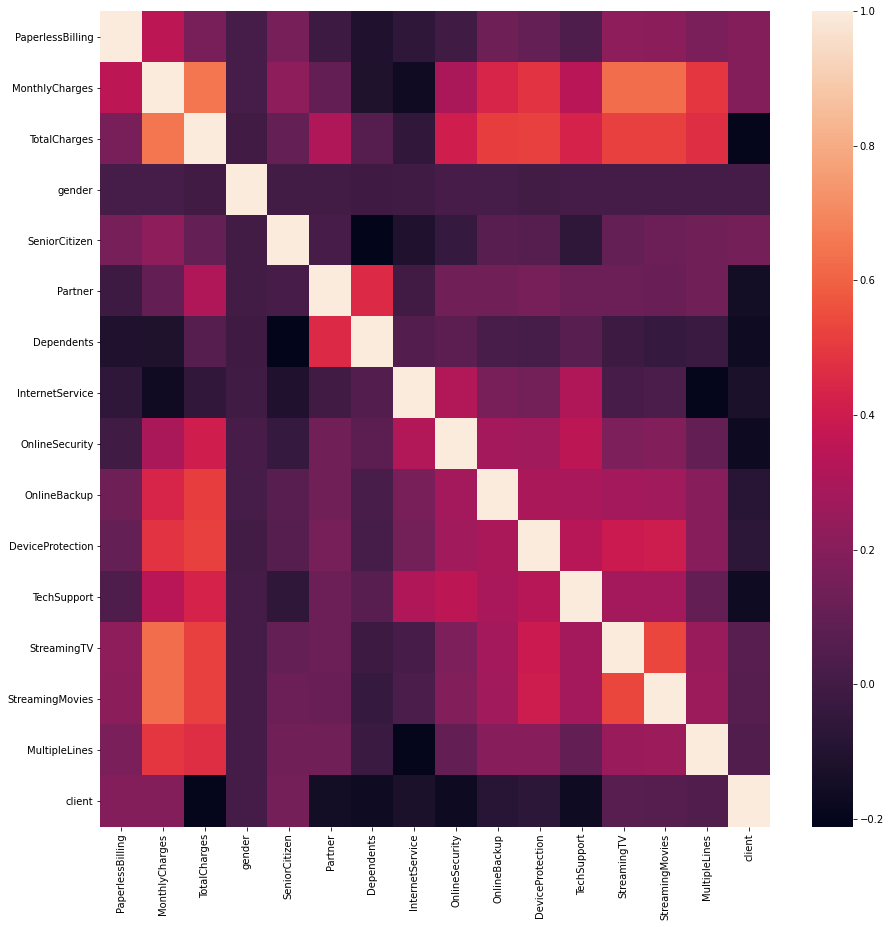

In [22]:
#Посмотрим тепловую карту

corr = alldata.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=False);

#Выделяются столбцы MonthlyCharges и TotalCharges, но проследить именно здесь корреляцию с "ушел или нет клиент" - не получится

<div class='alert alert-danger'> ⛔️
Ты используешь тут коэффициент корреляции Пирсона, данный метод не умеет работать с категориальными переменными. Для расчета корреляций на всем наборе данных воспользуйся непараметрическими методами. Также, если хочешь воспользоваться продвинутым коэффициентом корреляции, который способен работать с любыми типами данных, а также выявляет нелинейные взаимосвязи, то тебе понадобится phik. С его помощью можно получать адекватные значения корреляции для данных любой природы. https://phik.readthedocs.io/en/latest/introduction.html

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Ниже я попробую сделать 2 способами: методом Спирмена и Phik.
</div> 

<div class='alert alert-success'> 👍 вер 2
Спасибо за работу!

In [23]:
alldata_without_column = alldata.drop(columns=['BeginDate', 'EndDate'])

In [24]:
from scipy.stats import spearmanr

#напечатаем ранговую корреляцию Спирмена и p-значение

column = alldata_without_column.columns
for i in column:
    rho, p = spearmanr(alldata[i], alldata['client'])
    print('rho:', rho,'p:', p,',', i)

rho: -0.4062615766488807 p: 3.779860316096388e-278 , Type
rho: 0.1918253316664679 p: 2.3565543205817954e-59 , PaperlessBilling
rho: 0.10226975470600298 p: 7.71294906755859e-18 , PaymentMethod
rho: 0.18500502770975805 p: 2.897810671305135e-55 , MonthlyCharges
rho: -0.2299815972633727 p: 3.392540599193533e-85 , TotalCharges
rho: 0.00861209507899781 p: 0.4699045390980453 , gender
rho: 0.1508893281764731 p: 3.8398600557847846e-37 , SeniorCitizen
rho: -0.15044754495917653 p: 6.2207311296213e-37 , Partner
rho: -0.16422140157972526 p: 9.140432989088978e-44 , Dependents
rho: -0.12421382390260384 p: 1.2769571822119585e-25 , InternetService
rho: -0.1712262919485527 p: 1.7632588168538315e-47 , OnlineSecurity
rho: -0.0822548689381425 p: 4.727291732056459e-12 , OnlineBackup
rho: -0.06615979128028991 p: 2.7381602498197746e-08 , DeviceProtection
rho: -0.16467355590159383 p: 5.322253267505674e-44 , TechSupport
rho: 0.0632277461187574 p: 1.0926020701631042e-07 , StreamingTV
rho: 0.06138154801518704 p: 

Коэффициент корреляции Пирсона (rho) измеряет степень линейной зависимости между двумя количественными переменными. Чем ближе rho к -1 или 1, тем сильнее линейная зависимость между переменными. Если rho близко к 0, то между переменными практически нет линейной зависимости.

Таким образом, наибольшая взаимосвязь прослеживается у данных: Type, PaperlessBilling, MonthlyCharges, TotalCharges

In [25]:
#метод phik
from scipy.stats import chi2_contingency

# Создаем таблицу сопряженности

column = alldata.columns
for i in column:
    contingency_table = pd.crosstab(alldata[i], alldata['client'])

# Рассчитываем статистику хи-квадрат и коэффициент корреляции phi-k
    chi2, p, dof, stat = chi2_contingency(contingency_table)

# Выводим результаты
    print(i)
    print("Chi-square statistic: ", chi2)
    print("p-value: ", p)
    print("Degrees of freedom: ", dof)
    print("Stat", stat)
    print("----------------------------------------")
    

BeginDate
Chi-square statistic:  1233.234880000051
p-value:  2.1140874045046812e-208
Degrees of freedom:  76
Stat [[  2.20389039   0.79610961]
 [  1.46926026   0.53073974]
 [  2.20389039   0.79610961]
 [  5.1424109    1.8575891 ]
 [268.87462729  97.12537271]
 [130.764163    47.235837  ]
 [ 83.74783473  30.25216527]
 [ 71.99375266  26.00624734]
 [ 71.25912253  25.74087747]
 [ 71.99375266  26.00624734]
 [ 60.23967059  21.76032941]
 [ 52.8933693   19.1066307 ]
 [ 58.77041034  21.22958966]
 [ 56.56651995  20.43348005]
 [ 55.09725969  19.90274031]
 [ 55.09725969  19.90274031]
 [ 58.77041034  21.22958966]
 [ 42.60854749  15.39145251]
 [ 50.68947892  18.31052108]
 [ 54.36262956  19.63737044]
 [ 58.03578021  20.96421979]
 [ 44.81243788  16.18756212]
 [ 48.48558853  17.51441147]
 [ 49.22021866  17.77978134]
 [ 59.50504047  21.49495953]
 [ 54.36262956  19.63737044]
 [ 49.95484879  18.04515121]
 [ 41.87391736  15.12608264]
 [ 53.62799943  19.37200057]
 [ 44.81243788  16.18756212]
 [ 53.62799943  

Статистика хи-квадрат рассчитывается как сумма квадратов разностей между ожидаемыми и фактическими частотами появления каждой категории в каждой переменной, нормированных на ожидаемые частоты. Чем больше статистика хи-квадрат, тем более вероятно, что существует статистическая связь между переменными.

Таким образом, наибольшая взаимосвязь прослеживается у данных: BeginDate, EndDate,  Type, TotalCharges

BeginDate 
 2014-02-01    366
2019-10-01    237
2019-09-01    237
2019-11-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-12-01      3
2013-10-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64


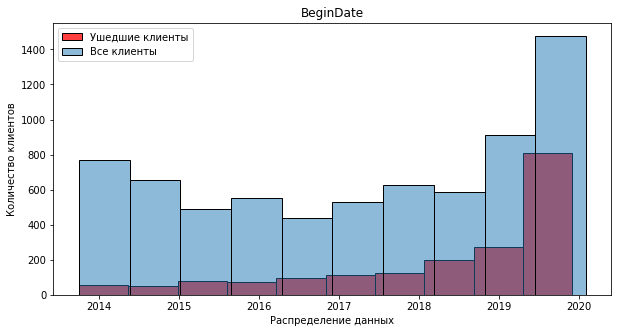

EndDate 
 2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: EndDate, dtype: int64


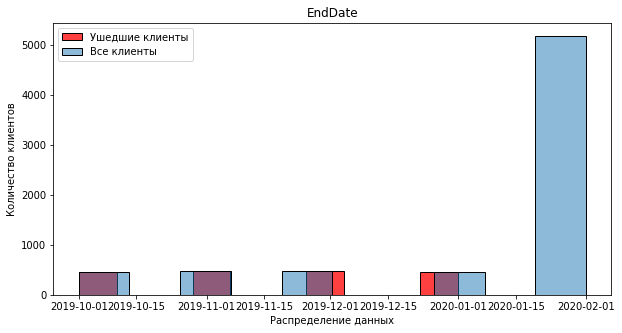

Type 
 Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64


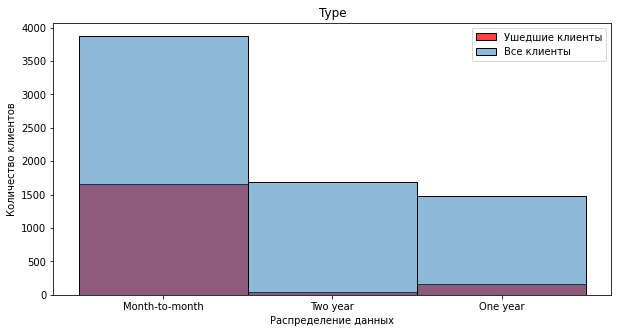

PaperlessBilling 
 1    4171
0    2872
Name: PaperlessBilling, dtype: int64


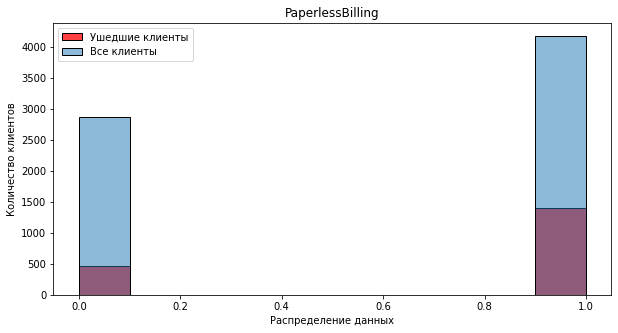

PaymentMethod 
 Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64


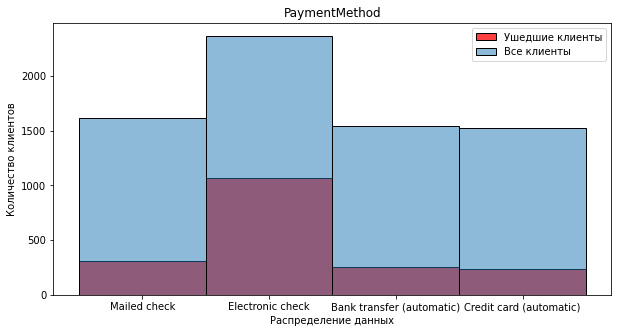

MonthlyCharges 
 19     587
20     546
25     187
24     179
80     165
      ... 
118      6
42       6
28       3
22       1
37       1
Name: MonthlyCharges, Length: 99, dtype: int64


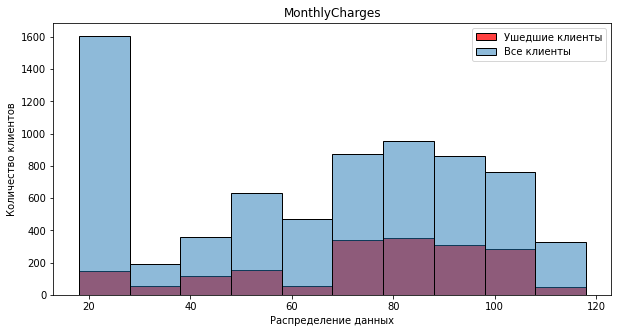

TotalCharges 
 19      77
20      76
69      41
45      37
70      34
        ..
1592     1
4532     1
6581     1
5686     1
6141     1
Name: TotalCharges, Length: 3847, dtype: int64


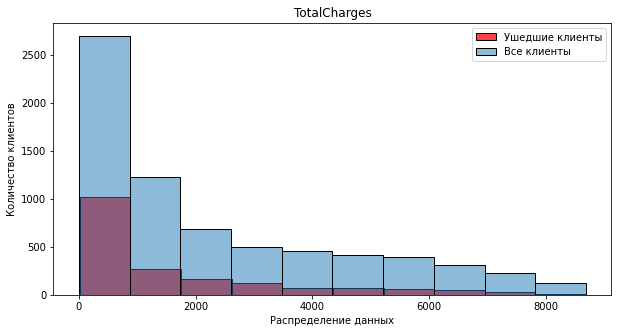

gender 
 0    3555
1    3488
Name: gender, dtype: int64


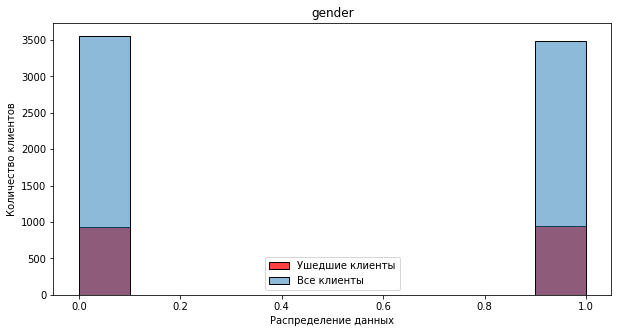

SeniorCitizen 
 0    5901
1    1142
Name: SeniorCitizen, dtype: int64


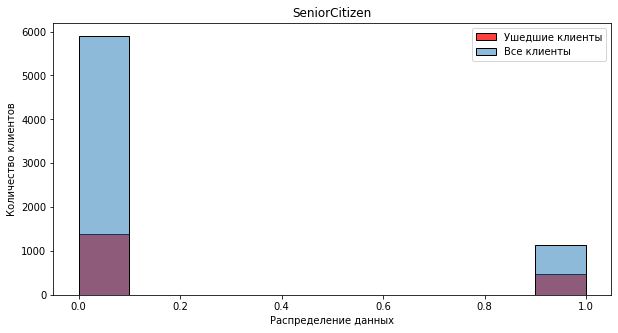

Partner 
 0    3641
1    3402
Name: Partner, dtype: int64


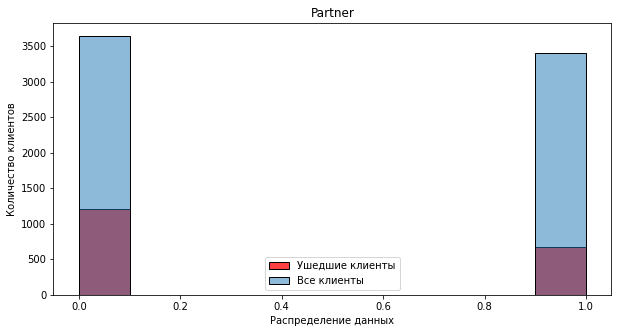

Dependents 
 0    4933
1    2110
Name: Dependents, dtype: int64


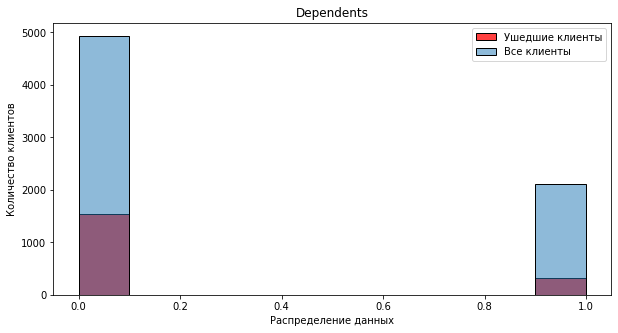

InternetService 
 0    4622
1    2421
Name: InternetService, dtype: int64


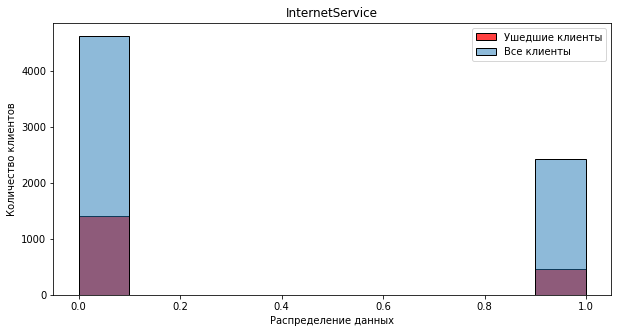

OnlineSecurity 
 0    5024
1    2019
Name: OnlineSecurity, dtype: int64


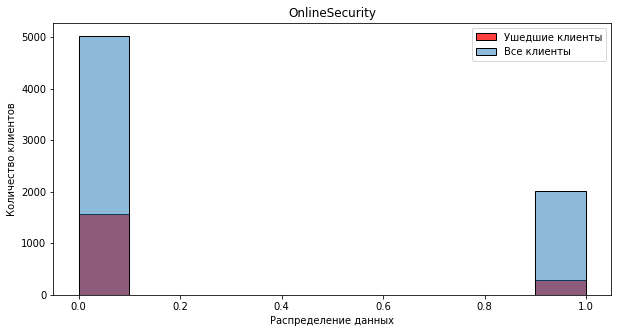

OnlineBackup 
 0    4614
1    2429
Name: OnlineBackup, dtype: int64


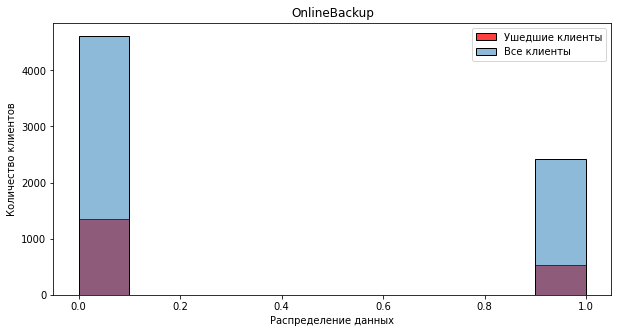

DeviceProtection 
 0    4621
1    2422
Name: DeviceProtection, dtype: int64


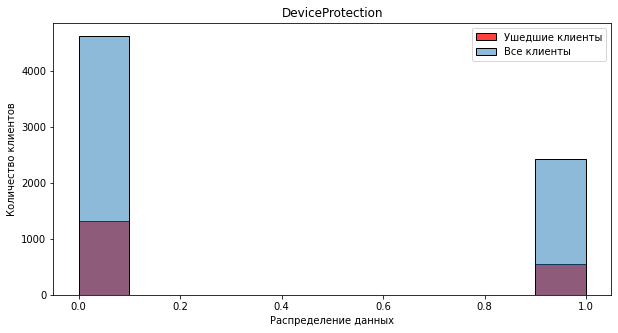

TechSupport 
 0    4999
1    2044
Name: TechSupport, dtype: int64


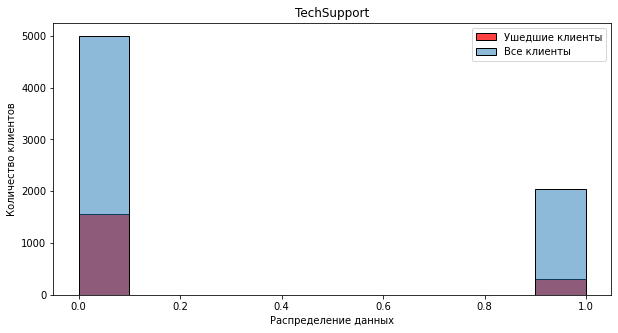

StreamingTV 
 0    4336
1    2707
Name: StreamingTV, dtype: int64


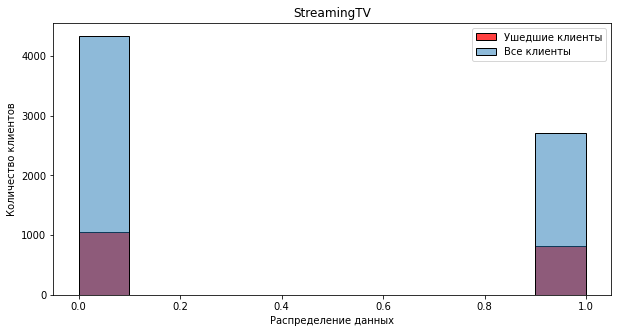

StreamingMovies 
 0    4311
1    2732
Name: StreamingMovies, dtype: int64


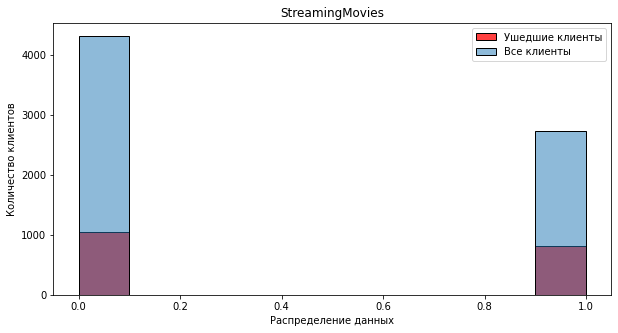

MultipleLines 
 0    4072
1    2971
Name: MultipleLines, dtype: int64


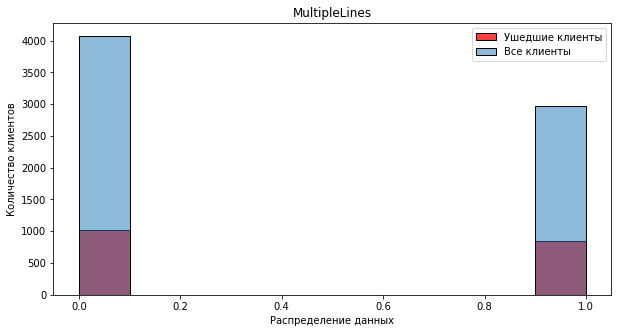

client 
 0    5174
1    1869
Name: client, dtype: int64


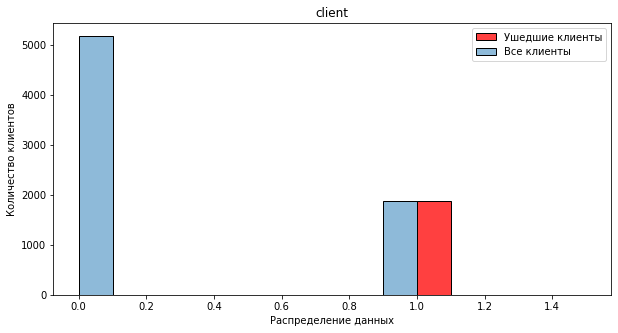

In [26]:
#Просмотрим все столбцы на ушедших клиентов

column = alldata.columns

for i in column:
  print(i,'\n',alldata[i].value_counts())
  plt.figure(figsize=(10, 5))
  ax = sns.histplot(alldata.query('client == 1')[i],
                  color='r', 
                  label='Ушедшие клиенты', bins=10)
  sns.histplot(alldata[i],
             ax=ax, 
             alpha=0.5, 
             label='Все клиенты', bins=10)
  ax.legend()
  plt.title(i)
  plt.ylabel('Количество клиентов')
  plt.xlabel('Распределение данных')
  plt.show()

<div class='alert alert-warning'> ⚠️
Хорошая автоматизация отрисовки, графики получились весьма аккуратными. Но столбцы иногда имеют разную ширину, а также смещаются относительно друг друга.

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Добавила bins=10, стало чуть лучше
</div> 

<div class='alert alert-danger'> ⛔️
Не хватает исследования таргета, баланса классов 

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Ниже добавила исследования 
</div>

<div class='alert alert-success'> 👍 вер 2

Просмотрим баланс классов целевого признака

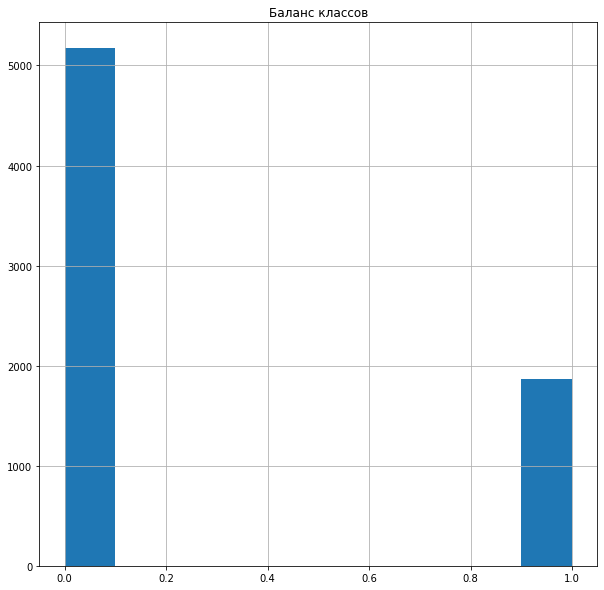

In [27]:
alldata['client'].hist(figsize=(10,10))
plt.title('Баланс классов');

Видим значительный первес в сторону пользователй, которые пользуются услугами заказчика

In [28]:
client_rate = round((alldata['client'].value_counts()[1] / alldata['client'].count()) * 100, 2)
client_rate

#Видим, что процент ушедших клиентов 26,54 %

26.54

По поводу исследования таргета не совсем поняла, так как в принципе были просмотрены все столбцы данных на ушедших клиентов и соответсвенно оставшихся. По исследованию целевого признака сделаю еще тогда такие графики, которые могут показать наибольшую взаимосвязь.

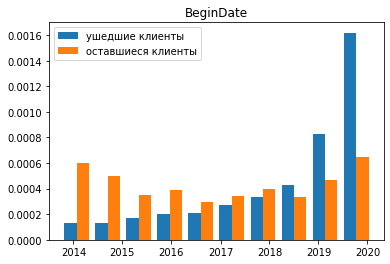

In [29]:
plt.hist([alldata[alldata.client == 1].BeginDate, alldata[alldata.client == 0].BeginDate], label=['ушедшие клиенты', 'оставшиеся клиенты'], density=True);
plt.legend();
plt.title('BeginDate');
plt.show();

#Видим, что оставшихся клиентов много, кто начал пользоватья в 2014, 2015, потом начался спад и с 2018 снова рост.

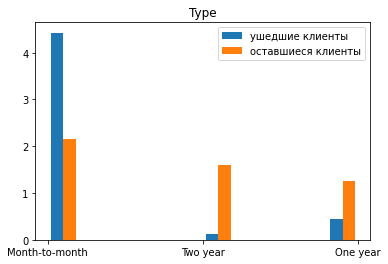

In [30]:
plt.hist([alldata[alldata.client == 1].Type, alldata[alldata.client == 0].Type], label=['ушедшие клиенты', 'оставшиеся клиенты'], density=True);
plt.legend();
plt.title('Type');
plt.show();

#Видим, что оставшихся клиентов больше также с помесячной оплатой, чем на 2 и 1 год. Но ушедших все же много также именно с помесячной.
#Но оплата на 2 года и помесячна по количеству оставшихся приблизительно одинакова, с ушедшими же очень сильная разница.

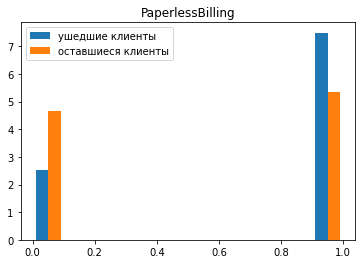

In [31]:
plt.hist([alldata[alldata.client == 1].PaperlessBilling, alldata[alldata.client == 0].PaperlessBilling], label=['ушедшие клиенты', 'оставшиеся клиенты'], density=True);
plt.legend();
plt.title('PaperlessBilling');
plt.show();

# С безналичной оплатой клиентов, которые остались примерно столько же (чуть больше) сколько и с наличной. 

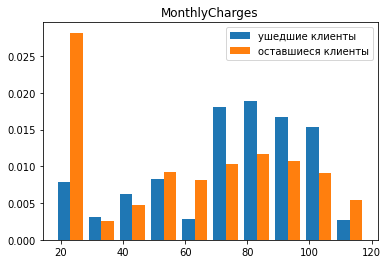

In [32]:
plt.hist([alldata[alldata.client == 1].MonthlyCharges, alldata[alldata.client == 0].MonthlyCharges], label=['ушедшие клиенты', 'оставшиеся клиенты'], density=True);
plt.legend();
plt.title('MonthlyCharges');
plt.show();

# Cреди ушедших клиентов больше значений помесячной оплаты в интервале от 70 до 110. 
# Среди оставшихся очень много тех, кто платит в месяц 20. 
# Ушедших клиентов с ежемесячным платежом в 20 больше, чем клиентов с ежемесячным платежом в 30, 40, 60 и 110.

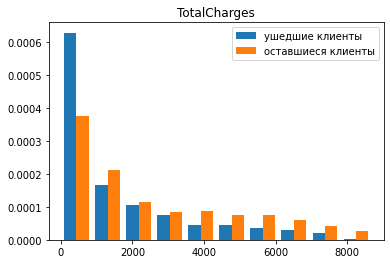

In [33]:
plt.hist([alldata[alldata.client == 1].TotalCharges, alldata[alldata.client == 0].TotalCharges], label=['ушедшие клиенты', 'оставшиеся клиенты'], density=True);
plt.legend();
plt.title('TotalCharges');
plt.show();

# Больше всего оставшихс клиентов, кто тратил всего на услуги меньше 2000, однако ушедших также много тех, кто платил даже до 1000. 

<div class='alert alert-danger'> ⛔️ вер 2
Не хватает автоматизации отрисовки графиков, следующий этап начни с того, что отрисуй эти графики в цикле. 

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> автоматизация отрисовки графиков ниже
</div>

***Вывод:***

Больше всего клиентов с: 
- помесячной оплатой
- безналичным расчетом
- методом оплаты - электронный чек
- ежемесячные траты в значениях 20-30
- тех, кто потратил в значениях 0-1000
- по гендеру практически ровно
- нет наличия пенсионного статуса
- равнозначно по наличию партнера
- нет тех, кто на еждевении
- не используют интернет
- не используют платные дополнительные услуги

***Стоит ориентироваться на клиентов, которые не ушли:***
- те, которые продолжительное время пользуются услугами (с 2014 года, в 2020 много ушло) 
- оплачивают на 2 года услуги 
- не пользуются электронным чеком 
- трата в значениях около 20 в месяц 
- без статуса пенсионер 
- есть партнер
- не используют интернет


Также стоит заметить, что дополнительные услуги практически не влиют на то, уйдет или останется клиент. От услуг отказываются те, кто платил больше и помесячно, что логично. Возможно в онлайн оплате есть проблемы с электронным чеком (потому что это мне кажется алогично, так как электронный чек обычно достаточно удобен).

<div class='alert alert-success'> 👍
Выводы получились вполне корректными

***В конце еще раз повторю план:***

Первый этап:

Загрузка данных
Исследовательский анализ данных. Делаем первичную предобработку данных, проверяем пропуски, дубликаты, нужного ли типа данные. Делаем их визуализацию.
Моделирование Обучаем модели, подбираем гиперпараметры, проверяем на кросс валидацию.
Тестирование Делаем подсчет метрик и выводы
Второй этап:

Разделяем данные на тест (25% данных) и трейн, фиксируем random state. Таргет определяется по полю end_date, если присутствует дата, значит клиент ушел, иначе клиент все еще пользуется нашими услугами. Дата выгрузки датасета 1 февраля 2020 года. На тест отправляется только лучшая модель, выбранная на кросс валидации.

Третий этап: Подготовить отчет с ответом на вопросы.

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Добавляю автоматизацию отрисовки графиков
</div>

<div class='alert alert-success'> 👍
Отличная работа!

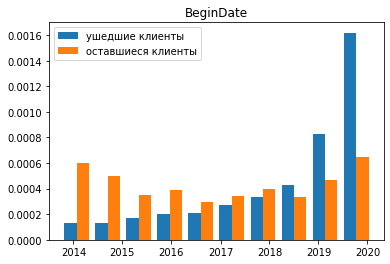

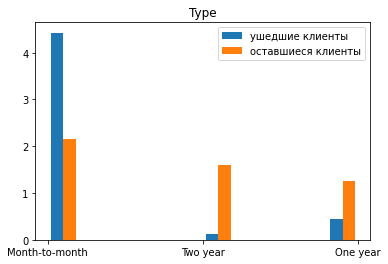

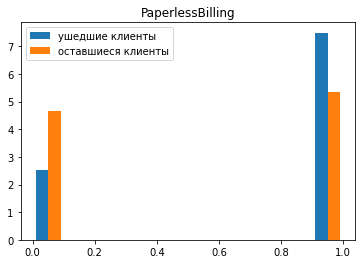

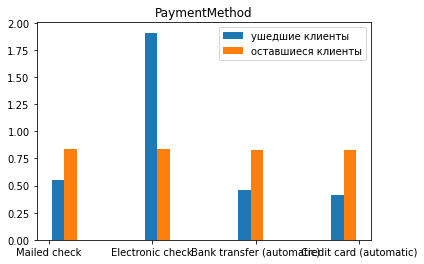

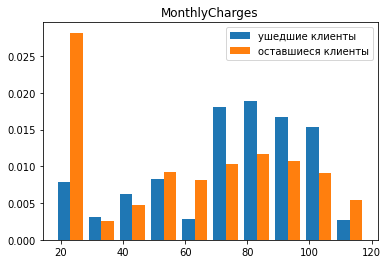

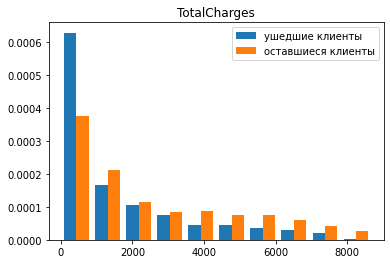

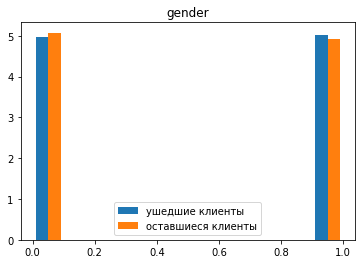

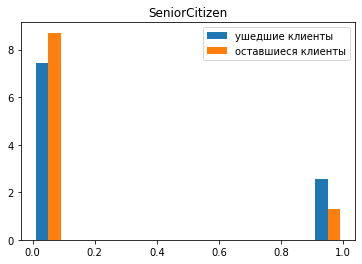

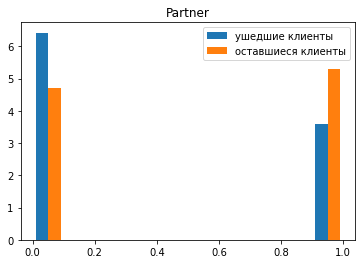

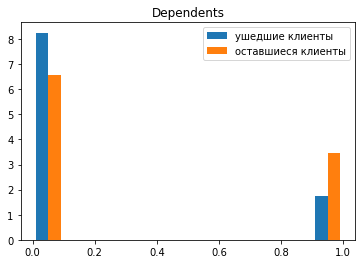

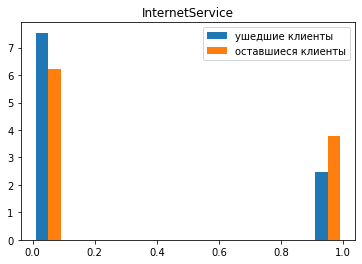

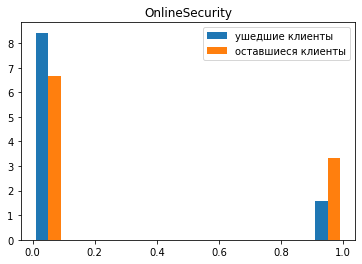

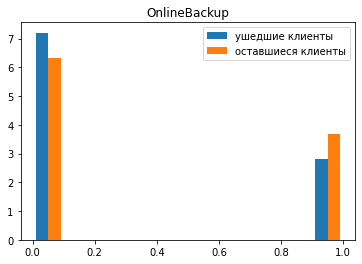

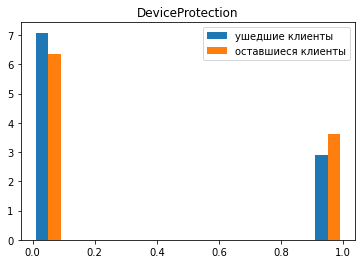

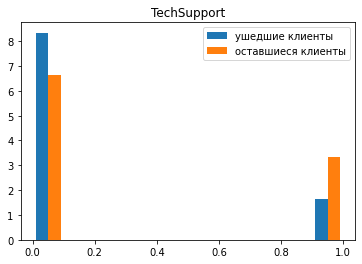

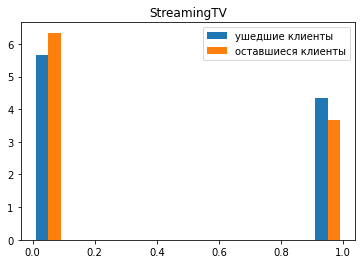

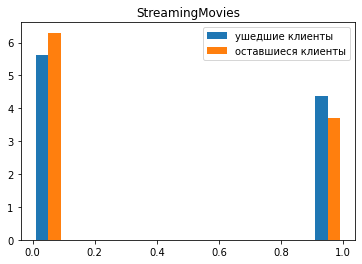

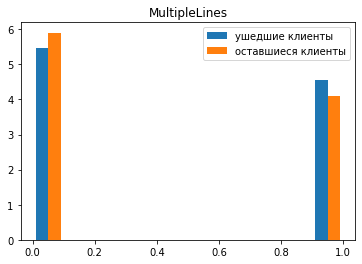

In [34]:
for col in column:
    if col not in ['EndDate', 'client']:
        plt.hist([alldata[alldata.client == 1][col], alldata[alldata.client == 0][col]], label=['ушедшие клиенты', 'оставшиеся клиенты'], density=True)
        plt.legend()
        plt.title(col)
        plt.show()

## Подготовка данных к моделированию

In [35]:
# Удалим ненужные для обучения столбцы фактора времени

alldata.drop(columns=['BeginDate', 'EndDate'], inplace=True)

In [36]:
alldatamodel = alldata.copy()

In [37]:
alldatamodel

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,client
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,1,Electronic check,29,29,1,0,1,0,1,0,1,0,0,0,0,0,0
5575-GNVDE,One year,0,Mailed check,56,1889,0,0,0,0,1,1,0,1,0,0,0,0,0
3668-QPYBK,Month-to-month,1,Mailed check,53,108,0,0,0,0,1,1,1,0,0,0,0,0,1
7795-CFOCW,One year,0,Bank transfer (automatic),42,1840,0,0,0,0,1,1,0,1,1,0,0,0,0
9237-HQITU,Month-to-month,1,Electronic check,70,151,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,One year,1,Mailed check,84,1990,0,0,1,1,1,1,0,1,1,1,1,1,0
2234-XADUH,One year,1,Credit card (automatic),103,7362,1,0,1,1,0,0,1,1,0,1,1,1,0
4801-JZAZL,Month-to-month,1,Electronic check,29,346,1,0,1,1,1,1,0,0,0,0,0,0,0


In [38]:
# преобразуем категориальные переменные в числовые
alldatamodel = pd.get_dummies(alldatamodel, columns = ['Type','PaymentMethod'], drop_first = True)

<div class='alert alert-danger'> ⛔️

а почему в итоге применяется pd.get_dummies ?

<div class='alert alert-warning'> ⚠️
Лучше делать такое кодирование с помощью функций из библиотеки sklearn. В таком случае у тебя будет возможность сохранить артефакты трансформера и в будущем поддерживать в работоспособности пайплайн вне зависимости от изменения в данных. Например в будущем могут появиться новые категории внутри признака, после трансформации появится новый столбец, естественно сломается и модель тк не сможет обработать новый датасет.


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Далее я попробовала сделать с encoder, но он требует установки новой библиотеки. Если я установила правильно (pip install -U scikit-learn), то все равно не сработало, не смог найти 'categorical_features' (TypeError: __init__() got an unexpected keyword argument 'categorical_features'). Поэтому оставляю кодировку с pd.get_dummies.
</div>

In [39]:
#C encoder  код примерно был бы таким: 

alldatamodelencoder2 = alldata.copy()
encoder = OrdinalEncoder()
encoder.fit(alldatamodelencoder2[['Type','PaymentMethod']])
alldatamodelencoder2[['Type','PaymentMethod']] = encoder.transform(alldatamodelencoder2[['Type','PaymentMethod']])
print(alldatamodelencoder2)

            Type  PaperlessBilling  PaymentMethod  MonthlyCharges  \
customerID                                                          
7590-VHVEG   0.0                 1            2.0              29   
5575-GNVDE   1.0                 0            3.0              56   
3668-QPYBK   0.0                 1            3.0              53   
7795-CFOCW   1.0                 0            0.0              42   
9237-HQITU   0.0                 1            2.0              70   
...          ...               ...            ...             ...   
6840-RESVB   1.0                 1            3.0              84   
2234-XADUH   1.0                 1            1.0             103   
4801-JZAZL   0.0                 1            2.0              29   
8361-LTMKD   0.0                 1            3.0              74   
3186-AJIEK   2.0                 1            0.0             105   

            TotalCharges  gender  SeniorCitizen  Partner  Dependents  \
customerID                    

In [40]:
pip install -U scikit-learn

     |████████████████████████████████| 9.5 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 78.6 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [41]:
'''
encoder = OneHotEncoder(categorical_features = [0, 2])
encoder.fit(alldatamodel)
alldatamodel_encoded = encoder.transform(alldatamodel)
'''

'\nencoder = OneHotEncoder(categorical_features = [0, 2])\nencoder.fit(alldatamodel)\nalldatamodel_encoded = encoder.transform(alldatamodel)\n'

In [42]:
'''
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
alldatamodel_new = onehotencoder.fit_transform(alldatamodel.values, categorical_features = [0, 2])
pd.DataFrame(alldatamodel_new.toarray(),
columns=onehotencoder.categories_).head(10)


from sklearn.preprocessing import OneHotEncoder, ColumnTransformer
ct = ColumnTransformer([("one_hot_encoder", OneHotEncoder(), [0, 2])])
alldatamodel_encoded = ct.fit_transform(alldatamodel)
'''


'\nfrom sklearn.preprocessing import OneHotEncoder\nonehotencoder = OneHotEncoder()\nalldatamodel_new = onehotencoder.fit_transform(alldatamodel.values, categorical_features = [0, 2])\npd.DataFrame(alldatamodel_new.toarray(),\ncolumns=onehotencoder.categories_).head(10)\n\n\nfrom sklearn.preprocessing import OneHotEncoder, ColumnTransformer\nct = ColumnTransformer([("one_hot_encoder", OneHotEncoder(), [0, 2])])\nalldatamodel_encoded = ct.fit_transform(alldatamodel)\n'

In [43]:
#Разделим датасет на тренировочную и тестовую выборки

features = alldatamodel.drop(['client'], axis=1)
target = alldatamodel['client']


X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)


In [44]:
alldatamodel

,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,MultipleLines,client,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,29,29,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
5575-GNVDE,0,56,1889,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,1
3668-QPYBK,1,53,108,0,0,0,0,1,1,1,...,0,0,0,0,1,0,0,0,0,1
7795-CFOCW,0,42,1840,0,0,0,0,1,1,0,...,1,0,0,0,0,1,0,0,0,0
9237-HQITU,1,70,151,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,1,84,1990,0,0,1,1,1,1,0,...,1,1,1,1,0,1,0,0,0,1
2234-XADUH,1,103,7362,1,0,1,1,0,0,1,...,0,1,1,1,0,1,0,1,0,0
4801-JZAZL,1,29,346,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,1,0


<div class='alert alert-success'> 👍
Разделение на выборки, выполнено корректно 

In [45]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5282, 20), (5282,), (1761, 20), (1761,))

In [46]:
data_info(X_test)

,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,,,,,,,,,,,
3679-XASPY,0,19,19,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0
7008-LZVOZ,1,25,1672,0,0,1,1,0,0,0,0,0,0,0,1,0,1,1,0,0
0122-OAHPZ,1,73,511,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
9013-AQORL,0,45,2108,1,0,0,1,1,0,1,1,0,0,1,0,0,0,1,0,0
0909-SELIE,1,80,4860,0,0,1,0,1,1,1,1,1,0,1,1,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 1761 entries, 2656-FMOKZ to 4119-ZYPZY
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   PaperlessBilling                       1761 non-null   int64
 1   MonthlyCharges                         1761 non-null   int64
 2   TotalCharges                           1761 non-null   int64
 3   gender                                 1761 non-null   int64
 4   SeniorCitizen                          1761 non-null   int64
 5   Partner                                1761 non-null   int64
 6   Dependents                             1761 non-null   int64
 7   InternetService                        1761 non-null   int64
 8   OnlineSecurity                         1761 non-null   int64
 9   OnlineBackup                           1761 non-null   int64
 10  DeviceProtection                       1761 non-null   int64
 11  TechSupport         

None

,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000
mean,0.604770,66.223737,2415.802385,0.512209,0.162408,0.486087,0.303805,0.339012,0.279955,0.367405,0.359455,0.310051,0.414537,0.420216,0.450312,0.208404,0.253265,0.225440,0.327655,0.233390
std,0.489039,30.256365,2323.896796,0.499993,0.368929,0.499948,0.460030,0.473508,0.449104,0.482235,0.479977,0.462646,0.492782,0.493734,0.497666,0.406283,0.435005,0.417991,0.469492,0.423109
min,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,41.000000,418.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,73.000000,1579.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,90.000000,4108.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,118.000000,8670.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


 
пропуски: PaperlessBilling                         0
MonthlyCharges                           0
TotalCharges                             0
gender                                   0
SeniorCitizen                            0
Partner                                  0
Dependents                               0
InternetService                          0
OnlineSecurity                           0
OnlineBackup                             0
DeviceProtection                         0
TechSupport                              0
StreamingTV                              0
StreamingMovies                          0
MultipleLines                            0
Type_One year                            0
Type_Two year                            0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
PaymentMethod_Mailed check               0
dtype: int64
 
дубликаты: 27
 
уникальные значения PaperlessBilling
[0 1]
уникальные значения MonthlyCharges
[ 18  19  20  21  2

In [47]:
#Проведем масштабирование признаков

numeric_columns = ['MonthlyCharges', 'TotalCharges']

In [48]:
scaler = StandardScaler()
scaler.fit(X_train[numeric_columns])

features_train = X_train.copy()
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])

features_test = X_test.copy()
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])


target_train = y_train.copy()
target_test = y_test.copy()


<div class='alert alert-success'> 👍
Масштабирование выполнено корректно, но тут же лучше делать и кодирование признаков 

In [49]:
features_test

,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,,,,,,,,,,,
2656-FMOKZ,1,0.344774,-0.484835,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
8966-OIQHG,0,-1.454597,-0.793439,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4854-SSLTN,0,-0.155051,-0.936831,0,0,1,1,1,1,1,0,1,0,0,0,0,1,0,0,1
5172-RKOCB,1,1.477711,2.512142,0,0,1,0,0,1,1,0,1,1,1,1,0,1,1,0,0
5419-JPRRN,1,1.244460,-0.949745,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5141-ZUVBH,0,0.977886,-0.607297,1,0,0,1,0,1,0,1,1,0,1,0,0,0,0,0,0
6029-CSMJE,1,-1.287988,-0.798783,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4614-NUVZD,1,0.578026,-0.958652,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [50]:
alldata['client'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: client, dtype: float64

In [51]:
# Закоментила прошлую функцию для баланса классов, задала их в моделях

In [52]:
'''
def upsample(features, target, repeat):     
    features_zeros = features[target == 0]     
    features_ones = features[target == 1]     
    target_zeros = target[target == 0]     
    target_ones = target[target == 1] 

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)     
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)     
    
    features_upsampled, target_upsampled = shuffle(         
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)          
    
    return features_upsampled, target_upsampled
'''

'\ndef upsample(features, target, repeat):     \n    features_zeros = features[target == 0]     \n    features_ones = features[target == 1]     \n    target_zeros = target[target == 0]     \n    target_ones = target[target == 1] \n\n    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)     \n    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)     \n    \n    features_upsampled, target_upsampled = shuffle(         \n        features_upsampled, target_upsampled, random_state=RANDOM_STATE)          \n    \n    return features_upsampled, target_upsampled\n'

<div class='alert alert-danger'> ⛔️
Рекомендую пользоваться библиотечными реализациями функций в случае, если они доступны. В таком случае остальные члены команды смогут лучше понимать что происходит внутри той или иной функции. Разбираться в чужом самописном коде весьма тяжело, поэтому попробуй методы апсемплинга например из sklearn или более продвинутый SMOTE! Также в качестве доступного и весьма эффективного способа борьбы с дисбалансом является раздача весов классам. 


In [54]:
'''
# Ниже отрывок из конспекта, который я использовала:
def upsample2(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled
'''    

'\n# Ниже отрывок из конспекта, который я использовала:\ndef upsample2(features, target, repeat):\n    features_zeros = features[target == 0]\n    features_ones = features[target == 1]\n    target_zeros = target[target == 0]\n    target_ones = target[target == 1]\n    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)\n    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)\n    features_upsampled, target_upsampled = shuffle(\n    features_upsampled, target_upsampled, random_state=12345)\n    return features_upsampled, target_upsampled\n'

<div class='alert alert-danger'> ⛔️ вер 2
из-за дубликатов, которые делаются в этой функции, появляются утечки на кросс-валидации и метрика недостоверна. Библиотечные методы значит реализованные какими-то разработчиками и распространяющиеся как библиотеки, например sklearn. У тебя ниже кажется правильно все получалось со SMOTE. Но я бы на твоем месте, просто раздал веса классам 

<div class="alert alert-block alert-info">
<b>Вер 2. Комментарий студента:</b> Поняла, закоментила функцию, ниже для моделей добавила значение в константу class_weight = balance.  
    CatBoost не имеет class_weight='balanced', поэтому веса задала вручную.
</div>

<div class='alert alert-success'> 👍 вер 3

Отличная работа! 

In [55]:
'''
pip install -U imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

smt = SMOTE()
features_smote, target_smote = smt.fit_resample(features, target)
plt.figure(figsize=(12, 8))
plt.title('Repartition after SMOTE')
plt.legend()
plt.grid(False)
plt.show()

def ups(features, target, repeat):     
    features_zeros = features[target == 0]     
    features_ones = features[target == 1]
    
features_train = features_train.loc[train['client']==1]
features_train = features_train.loc[balancead.index.repeat(rat)]
train_n = pd.concat([features_train.loc[train['client']==0], features_train]).sample(frac=1)    
'''

"\npip install -U imblearn\nfrom collections import Counter\nfrom imblearn.over_sampling import SMOTE\nfrom sklearn.datasets import make_classification\n\nsmt = SMOTE()\nfeatures_smote, target_smote = smt.fit_resample(features, target)\nplt.figure(figsize=(12, 8))\nplt.title('Repartition after SMOTE')\nplt.legend()\nplt.grid(False)\nplt.show()\n\ndef ups(features, target, repeat):     \n    features_zeros = features[target == 0]     \n    features_ones = features[target == 1]\n    \nfeatures_train = features_train.loc[train['client']==1]\nfeatures_train = features_train.loc[balancead.index.repeat(rat)]\ntrain_n = pd.concat([features_train.loc[train['client']==0], features_train]).sample(frac=1)    \n"

In [56]:
#from imblearn.over_sampling import RandomOverSampler

In [57]:
#resampler = RandomOverSampler(random_state=42)

In [58]:
#features_train, target_train = upsample(features_train, target_train, 3)

In [59]:
#target_train.hist(figsize=(10,10))
#plt.title('Баланс классов');

***Вывод***
1. Данные разделены на тестовую и трейн выборки.  
2. Сделали кодирование признаков методом OHE
3. Провели масштабировнаие
4. Также выровняли дисбаланс классов для дальнейшего обучения 

## Обучение моделей

### LogisticRegression

In [60]:
%%time

modellr = LogisticRegression(random_state=RANDOM_STATE, class_weight = 'balanced')
hyperparams = [{ 'C':[0.1, 1, 10, 15, 100], 'solver':['newton-cg', 'lbfgs', 'liblinear'] }]
modellr = GridSearchCV(modellr, hyperparams, scoring='roc_auc', cv = 2)
modellr = modellr.fit(features_train, target_train)

#CPU times: user 2.62 s, sys: 5.27 s, total: 7.89 s
#Wall time: 7.89 s

CPU times: user 3.4 s, sys: 7.99 s, total: 11.4 s
Wall time: 11.4 s


<div class='alert alert-danger'> ⛔️
Райндом стейт задается в самой модели с использованием константы, по стандарту pep8 константы обозначаются заглавным шрифтом

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Задала RANDOM_STATE в самой модели
</div>

<div class='alert alert-success'> 👍 вер 2


In [61]:
print("Best params:", modellr.best_params_)

# Best params: {'C': 0.1, 'class_weight': 'balanced', 'random_state': 121222, 'solver': 'liblinear'}

Best params: {'C': 0.1, 'solver': 'liblinear'}


In [62]:
predictlr = modellr.best_estimator_.predict_proba(features_train)[:, 1]

In [63]:
print('roc_auc: ',roc_auc_score(target_train, predictlr))
# roc_auc:  0.8340842406656312

roc_auc:  0.8340842406656312


<div class='alert alert-success'> 👍
логрег обучен корректно 

### CatBoostClassifier

In [64]:
%%time

target = alldata['client']
class_weights = [1 - np.mean(target), np.mean(target)]

cbmodel = CatBoostClassifier(class_weights = class_weights, random_state=RANDOM_STATE) 
hyperparams = [{'iterations':[250, 500, 1000],
               'learning_rate': [0.1, 0.3],
               'depth' : range(2,10,3),
               'l2_leaf_reg': [3]}]

cbmodel = GridSearchCV(cbmodel, hyperparams, cv=2, scoring = 'roc_auc') 
cbmodel.fit(features_train, target_train)

#CPU times: user 58.9 s, sys: 3.21 s, total: 1min 2s
#Wall time: 1min 19s

0:	learn: 0.5950443	total: 47.1ms	remaining: 11.7s
1:	learn: 0.5311298	total: 48.1ms	remaining: 5.97s
2:	learn: 0.4800787	total: 48.9ms	remaining: 4.03s
3:	learn: 0.4423272	total: 49.8ms	remaining: 3.06s
4:	learn: 0.4151231	total: 50.6ms	remaining: 2.48s
5:	learn: 0.3866024	total: 51.5ms	remaining: 2.1s
6:	learn: 0.3715843	total: 52.4ms	remaining: 1.82s
7:	learn: 0.3583403	total: 53.4ms	remaining: 1.61s
8:	learn: 0.3464891	total: 54.3ms	remaining: 1.45s
9:	learn: 0.3366114	total: 55.3ms	remaining: 1.33s
10:	learn: 0.3292220	total: 56.2ms	remaining: 1.22s
11:	learn: 0.3218903	total: 57.1ms	remaining: 1.13s
12:	learn: 0.3180991	total: 58ms	remaining: 1.06s
13:	learn: 0.3144745	total: 58.9ms	remaining: 993ms
14:	learn: 0.3072483	total: 59.7ms	remaining: 936ms
15:	learn: 0.3034056	total: 60.4ms	remaining: 883ms
16:	learn: 0.3009656	total: 61ms	remaining: 836ms
17:	learn: 0.2968032	total: 61.7ms	remaining: 795ms
18:	learn: 0.2946458	total: 62.4ms	remaining: 758ms
19:	learn: 0.2923968	total:

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f2e384117c0>,
             param_grid=[{'depth': range(2, 10, 3),
                          'iterations': [250, 500, 1000], 'l2_leaf_reg': [3],
                          'learning_rate': [0.1, 0.3]}],
             scoring='roc_auc')

<div class='alert alert-danger'> ⛔️
почему тут другое число фолдов ? Крос валидация должна быть идентичной 

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Задала RANDOM_STATE в самой модели, исправила число фолдов, стало идентично первой модели
</div>

<div class='alert alert-success'> 👍 вер 2


In [65]:
print("Best params:", cbmodel.best_params_)

Best params: {'depth': 2, 'iterations': 250, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


In [66]:
predictcb = cbmodel.best_estimator_.predict_proba(features_train)[:, 1]
print('roc_auc: ',roc_auc_score(target_train, predictcb))

roc_auc:  0.8596007928108761


### RandomForestClassifier

In [67]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
%%time

rfmodel = RandomForestClassifier(class_weight = 'balanced', random_state=RANDOM_STATE) 
hyperparams = [{'n_estimators': [10, 50, 100],
                'max_depth': [5, 10, 20],
               'class_weight':['balanced']}]

rfmodel = GridSearchCV(rfmodel, hyperparams, cv=2, scoring = 'roc_auc') 
rfmodel.fit(features_train, target_train)

#CPU times: user 3.66 s, sys: 42.1 ms, total: 3.7 s
#Wall time: 3.72 s

CPU times: user 3.03 s, sys: 17.3 ms, total: 3.05 s
Wall time: 3.06 s


GridSearchCV(cv=2,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=121222),
             param_grid=[{'class_weight': ['balanced'],
                          'max_depth': [5, 10, 20],
                          'n_estimators': [10, 50, 100]}],
             scoring='roc_auc')

<div class='alert alert-warning'> ⚠️
А зачем каждый раз еще раз выполнять балансировку классов, если используется upsampling ? 

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Задала RANDOM_STATE в самой модели, число фолдов идентично первой модели
</div>

<div class='alert alert-success'> 👍 вер 2


In [69]:
print("Best params:", rfmodel.best_params_)

Best params: {'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 100}


In [70]:
predictrf = rfmodel.best_estimator_.predict_proba(features_train)[:, 1]
print('roc_auc: ', roc_auc_score(target_train, predictrf))

roc_auc:  0.8548793268139543


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> создам таблицу для выявления лучшей модели
</div>

In [71]:
datatable = [[0.8341155348629324],
        [0.8596007928108761],
        [0.8548793268139543]]

index = ["LogisticRegression", "CatBoostClissifier", "RandomForestClassifier"]

pd.DataFrame(data=datatable, index=index , columns=["roc_auc"])

,roc_auc
LogisticRegression,0.834116
CatBoostClissifier,0.859601
RandomForestClassifier,0.854879


<div class='alert alert-danger'> ⛔️ вер 2
Такие значения метрики из-за утечки данных, это из-за апсемплинга 

<div class="alert alert-block alert-info">
<b>вер 2 Комментарий студента</b> Переделала таблицу с значениями после того, как сделала балансировку в самих моделях.
</div>

<div class='alert alert-success'> 👍 вер 3
Теперь всё выглядит корректно 

## Тестирование

<div class='alert alert-danger'> ⛔️
На тест отправляется лучшая модель по метрике а кросс валидации 

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> На тренировочных данных выявили лучшую модель - RandomForestClassifier
</div>

<div class="alert alert-block alert-info">
<b>вер 2 Комментарий студента:</b> На тренировочных данных после балансировки в моделях лучшая модель - CatBoostClissifier
</div>

<div class='alert alert-success'> 👍 вер 2


In [72]:
#Закоментила остальные модели
'''
predictlr2 = modellr.best_estimator_.predict_proba(features_test)[:, 1]
print('roc_auc: ', roc_auc_score(target_test, predictlr2))

predictrf = rfmodel.best_estimator_.predict_proba(features_test)[:, 1]
print('roc_auc: ', roc_auc_score(target_test, predictrf))

'''

"\npredictlr2 = modellr.best_estimator_.predict_proba(features_test)[:, 1]\nprint('roc_auc: ', roc_auc_score(target_test, predictlr2))\n\npredictrf = rfmodel.best_estimator_.predict_proba(features_test)[:, 1]\nprint('roc_auc: ', roc_auc_score(target_test, predictrf))\n\n"

In [73]:
predictcb = cbmodel.best_estimator_.predict_proba(features_test)[:, 1]
print('roc_auc: ',roc_auc_score(target_test, predictcb))

roc_auc:  0.8569499151243469


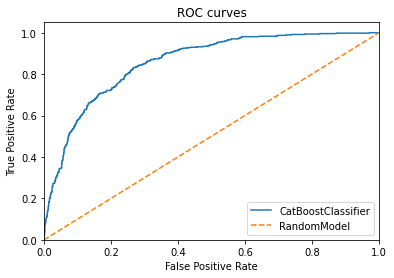

In [74]:
fig, ax = plt.subplots()

'''
fpr, tpr, treshold = roc_curve(target_test, predictlr2)
ax.plot(fpr, tpr, label='LogisticRegression')

fpr, tpr, treshold = roc_curve(target_test, predictrf)
ax.plot(fpr, tpr, label='RandomForestClassifier')

'''
fpr, tpr, treshold = roc_curve(target_test, predictcb)
ax.plot(fpr, tpr, label='CatBoostClassifier')

ax.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curves')

ax.legend()

plt.show()

***Выводы***

Полученные данные проанализированны, в ходе работы были решены проблемы для их предобработки. Все датасеты были объедины в один, в дальнейшем данные разделены на тестовую и трейн выборки со стратификацией, на тест отправилось 25% данных, провели кодирование с масштабировнаием, моделирование, тестирование. 


Важными этапами при выполнении работы были:

Сначала я проанализировала исходные данные и соеденила все в 1 таблицу.
Сделала предобработку данных (Приведение к нужному формату и типу, установление заглушек, убрала пропуски и дубликаты).
Выделила целевой признак "client", на основе того ушел клиент или нет.
Сделала визуализацию данных.
В дальнейшем данные были разделены на тестовую и трейн выборки, провела кодирование с помощью get_dummies, провела масштабировнаием с StandardScaler.
Выбрала 3 модели (RandomForestClassifier, LogisticRegression, CatBoostClassifier), нашла наилучшую из них с подобрвнными гиперпараметрами и кросс валидацией.
В итогге была обучена модель CatBoostClissifier с использованием подобранных гиперпараметрах, на тестовом наборе данных было достигнуто значение метрики ROC-AUC 0.8569.

Гиперпараметры для лучшей модели: 'depth': 2, 'iterations': 250, 'l2_leaf_reg': 3, 'learning_rate': 0.1.

Исходя из данных, больше всего клиентов с: 
- помесячной оплатой
- безналичным расчетом
- методом оплаты - электронный чек
- ежемесячные траты в значениях 20-30
- тех, кто потратил в значениях 0-1000
- по гендеру практически ровно
- нет наличия пенсионного статуса
- равнозначно по наличию партнера
- нет тех, кто на еждевении
- не используют интернет
- не используют платные дополнительные услуги

***Стоит ориентироваться на клиентов, которые не ушли:***
- те, которые продолжительное время пользуются услугами (с 2014 года, в 2020 много ушло) 
- оплачивают на 2 года услуги 
- не пользуются электронным чеком 
- трата в значениях около 20 в месяц 
- без статуса пенсионер 
- есть партнер
- не используют интернет


<div class='alert alert-success'> 👍 вер 3
Рад что тебе удалось так продуктивно поработать над правками, теперь у тебя получились вполне корректные результаты. Ты готова перейти к следуюбщему этапу. Не забудь вывести важность признаков, а также описать их способ обработки, чтобы по отчету было понятно как нужно готовить данные для модели. 

# ОТЧЕТ

1. Какие пункты плана были выполнены, а какие — нет (поясните почему)?

Ответ:

Были выполнены основные пункты по плану (загрузка данных, исследовательский анализ данных, моделирование, тестирование). Разбиение на трейн и тест происходило со стратификацией, на тест отправилось 25% данных.

Что не сделано, но могло бы быть выполнено: дополнительно на проверке модели возможно мне стоило бы еще добавить вычисление accuracy.

2. Какие трудности возникли и как вы их преодолели?

Основная трудность была со временем, так как были жесткие дедлайны. Поэтому не успела добавить какой-то короткий крутой код, разобраться с новыми методами, которые также можно было бы применить.

Также были трудности с достижением высокой метрики качества auc-roc, долго перебирала различные гиперпараметры и код.
Преодолела долгим перебиранием. 
Еще не совсем было понятно, в чем проблема утечки, оказалось, что из-за функции с балансом данных.

3. Какие ключевые шаги в решении задачи выделили?


Важными этапами при выполнении работы были:

1. Сначала я проанализировала исходные данные и соеденила все в 1 таблицу. 
2. Сделала предобработку данных (Приведение к нужному формату и типу, установление заглушек, убрала пропуски и дубликаты).
- преобразованы столбцы BeginDate и EndDate, замена в последнем no на 1 февраля 2020
- В MonthlyCharges изменен тип данных.
- Замены в остальных столбцах на 1 (yes) и 0 (no)
- Также соответсвующие замены в столбцах 'gender' и 'InternetService'.
3. Выделила целевой признак "client", на основе того ушел клиент или нет. (Если значение в столбце EndDate равно 0, то значит клиент остался, 1 - ушел.)
4. Сделала визуализацию данных. 
5. Сделала исследование целевого признака. Были сделаны графики, которые показали наибольшую взаимосвязь. 
- Использовала для анализа коэффициент корреляции Пирсона (rho), которыйизмерял степень линейной зависимости между двумя количественными переменными. Чем ближе rho к -1 или 1, тем сильнее линейная зависимость между переменными. Если rho близко к 0, то между переменными практически нет линейной зависимости.
- Наибольшая взаимосвязь прослеживалась у данных: Type, PaperlessBilling, MonthlyCharges, TotalCharges.
- Также проверила продвинутый коэффициент корреляции phik
6. В дальнейшем данные были разделены на тестовую и трейн выборки, провела кодирование с помощью get_dummies (но пример, как можно было бы использовать еще encoder также оставила), провела масштабировнаием с StandardScaler. 
7. Выбрала 3 модели (RandomForestClassifier, LogisticRegression, CatBoostClassifier), нашла наилучшую из них с подобранными гиперпараметрами и кросс валидацией методом GridSearchCV. 

4. Какая ваша итоговая модель и какое у неё качество?

В итоге была обучена модель CatBoostClissifier с использованием подобранных гиперпараметрах, на тестовом наборе данных было достигнуто значение метрики ROC-AUC 0.8569.

Гиперпараметры для лучшей модели: 'depth': 2, 'iterations': 250, 'l2_leaf_reg': 3, 'learning_rate': 0.1.

5. Важность признаков и способ их обработки. 

Признаки исследую методом feature_importances_ . Он позволяет оценить, насколько каждый признак влияет на предсказания модели. 

In [90]:
feature_import = pd.DataFrame(cbmodel.best_estimator_.feature_importances_, index = features_test.columns, columns=['importances'])
feature_import = feature_import.sort_values(by='importances', ascending=False)
feature_import

,importances
Type_Two year,33.155214
MonthlyCharges,24.151103
TotalCharges,19.353175
Type_One year,7.031325
PaymentMethod_Electronic check,4.564977
PaperlessBilling,2.436507
OnlineSecurity,2.204429
TechSupport,1.535607
StreamingMovies,1.087386
MultipleLines,0.861560


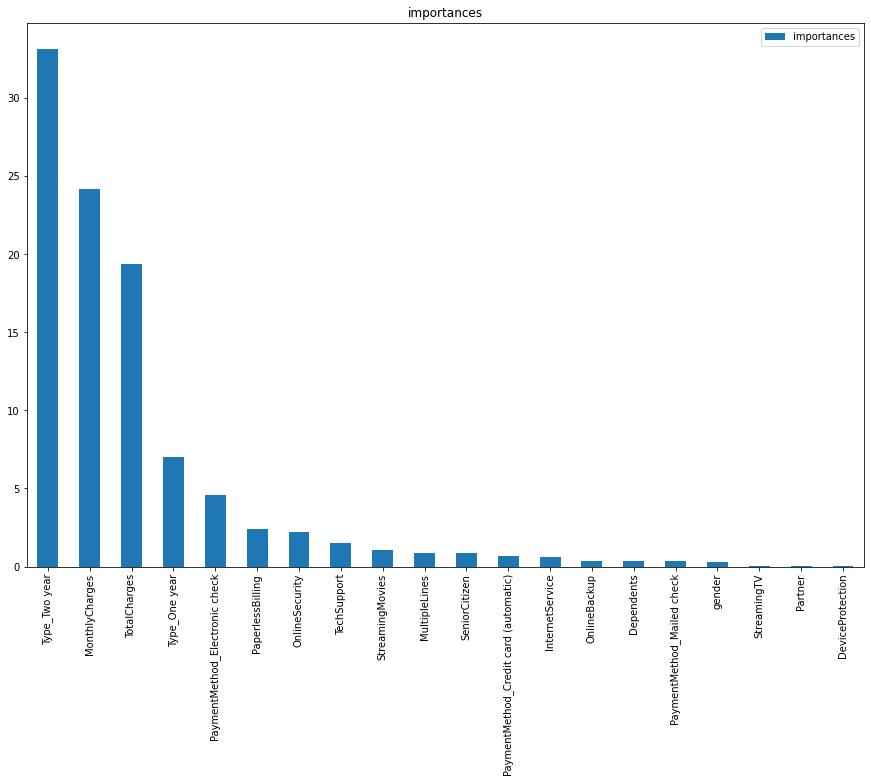

In [91]:
importances_df.plot(kind='bar', figsize=(15, 10), title='importances')
plt.show()

Вывод: Таким образом, в основном на предсказание влиют признаки оплаты услуги клиентом (Годовой или на 2 года оформлена услуга), а токже сколько тратит клиент на услугу (в месяц и общие траты всего). Меньше всего - дополнительные услуги, гендер и наличие партнера или еждевенца. 